In [1]:
#import pandas and sqlite
import pandas as pd
import sqlite3 as sl

In [2]:
#connecct to database object
conn = sl.connect('NYT_covid.db')
c = conn.cursor()

In [3]:
#confirm tables present
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print (name[0])

deaths
mask_use
states
us
regions
election
counties


In [4]:
#update counties table with most recent data
counties = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv', index_col=0, encoding='latin-1')

c.execute('DROP TABLE IF EXISTS counties')
c.execute('CREATE TABLE counties (date datetime, county str, state str, fips str, cases int, deaths int, confirmed_cases int, confirmed_deaths int, probable_cases int, probable_deaths int)')
conn.commit()

counties.to_sql('counties',conn, if_exists='replace')

In [5]:
df = pd.read_sql('''SELECT * FROM counties WHERE state = 'Illinois' AND county = 'Cook' ORDER by date asc''',conn)
df

,date,county,state,fips,cases,deaths
0,2020-01-24,Cook,Illinois,17031.0,1,0
1,2020-01-25,Cook,Illinois,17031.0,1,0
2,2020-01-26,Cook,Illinois,17031.0,1,0
3,2020-01-27,Cook,Illinois,17031.0,1,0
4,2020-01-28,Cook,Illinois,17031.0,1,0
...,...,...,...,...,...,...
286,2020-11-05,Cook,Illinois,17031.0,204977,5574
287,2020-11-06,Cook,Illinois,17031.0,210266,5742
288,2020-11-07,Cook,Illinois,17031.0,214924,5770
289,2020-11-08,Cook,Illinois,17031.0,218662,5798


In [6]:
df = pd.read_sql('''SELECT date, county, state, cases as 'Total_cases_to_date'
                    FROM counties 
                    WHERE state = 'Illinois'
                    AND county = 'Cook'
                    ''',conn)
df

,date,county,state,Total_cases_to_date
0,2020-01-24,Cook,Illinois,1
1,2020-01-25,Cook,Illinois,1
2,2020-01-26,Cook,Illinois,1
3,2020-01-27,Cook,Illinois,1
4,2020-01-28,Cook,Illinois,1
...,...,...,...,...
286,2020-11-05,Cook,Illinois,204977
287,2020-11-06,Cook,Illinois,210266
288,2020-11-07,Cook,Illinois,214924
289,2020-11-08,Cook,Illinois,218662


In [7]:
#we are going to explore LAG.  LAG is a window funcgtion that allows you to use values from previous rows.  
#By default, the offset is 1 (meaning the previous row is used)

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    WHERE state = 'Illinois'
                    AND county = 'Cook'
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-01-24,Illinois,Cook,NaN,1,NaN,0
1,2020-01-25,Illinois,Cook,0.0,1,0.0,0
2,2020-01-26,Illinois,Cook,0.0,1,0.0,0
3,2020-01-27,Illinois,Cook,0.0,1,0.0,0
4,2020-01-28,Illinois,Cook,0.0,1,0.0,0
...,...,...,...,...,...,...,...
286,2020-11-05,Illinois,Cook,3801.0,204977,33.0,5574
287,2020-11-06,Illinois,Cook,5289.0,210266,168.0,5742
288,2020-11-07,Illinois,Cook,4658.0,214924,28.0,5770
289,2020-11-08,Illinois,Cook,3738.0,218662,28.0,5798


In [8]:
# COMBINING WITH PARTITION BY ALLOWS US TO GROUP ALL THE COUNTIES TOGETHER

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY county ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY county ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    WHERE state = 'Illinois'
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-20,Illinois,Adams,NaN,1,NaN,0
1,2020-03-21,Illinois,Adams,0.0,1,0.0,0
2,2020-03-22,Illinois,Adams,0.0,1,0.0,0
3,2020-03-23,Illinois,Adams,0.0,1,0.0,0
4,2020-03-24,Illinois,Adams,0.0,1,0.0,0
...,...,...,...,...,...,...,...
22927,2020-11-05,Illinois,Woodford,29.0,898,0.0,19
22928,2020-11-06,Illinois,Woodford,23.0,921,0.0,19
22929,2020-11-07,Illinois,Woodford,33.0,954,0.0,19
22930,2020-11-08,Illinois,Woodford,34.0,988,0.0,19


In [9]:
#using different partitioning gives different results.  I am going to use fips to get this for all states/counties

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,0
1,2020-03-25,Alabama,Autauga,3.0,4,0.0,0
2,2020-03-26,Alabama,Autauga,2.0,6,0.0,0
3,2020-03-27,Alabama,Autauga,0.0,6,0.0,0
4,2020-03-28,Alabama,Autauga,0.0,6,0.0,0
...,...,...,...,...,...,...,...
716044,2020-11-05,Wyoming,Weston,14.0,203,0.0,1
716045,2020-11-06,Wyoming,Weston,91.0,294,0.0,1
716046,2020-11-07,Wyoming,Weston,2.0,296,0.0,1
716047,2020-11-08,Wyoming,Weston,10.0,306,-1.0,0


In [10]:
df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county''',conn)

df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,0
1,2020-03-25,Alabama,Autauga,3.0,4,0.0,0
2,2020-03-26,Alabama,Autauga,2.0,6,0.0,0
3,2020-03-27,Alabama,Autauga,0.0,6,0.0,0
4,2020-03-28,Alabama,Autauga,0.0,6,0.0,0
...,...,...,...,...,...,...,...
716044,2020-11-05,Wyoming,Weston,14.0,203,0.0,1
716045,2020-11-06,Wyoming,Weston,91.0,294,0.0,1
716046,2020-11-07,Wyoming,Weston,2.0,296,0.0,1
716047,2020-11-08,Wyoming,Weston,10.0,306,-1.0,0


In [11]:
#Now we will add in some rolling averages for new cases and new deaths, we have to use a cte to do this 

df = pd.read_sql('''WITH cte as (SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county)
                    
                    SELECT date, state, county, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    ORDER BY state, county, date
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,NaN,0,NaN
1,2020-03-25,Alabama,Autauga,3.0,4,3.000000,0.0,0,0.000000
2,2020-03-26,Alabama,Autauga,2.0,6,2.500000,0.0,0,0.000000
3,2020-03-27,Alabama,Autauga,0.0,6,1.666667,0.0,0,0.000000
4,2020-03-28,Alabama,Autauga,0.0,6,1.250000,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...
716044,2020-11-05,Wyoming,Weston,14.0,203,6.857143,0.0,1,0.142857
716045,2020-11-06,Wyoming,Weston,91.0,294,19.285714,0.0,1,0.142857
716046,2020-11-07,Wyoming,Weston,2.0,296,19.000000,0.0,1,0.142857
716047,2020-11-08,Wyoming,Weston,10.0,306,20.285714,-1.0,0,0.000000


In [12]:
cook = pd.read_sql('''WITH cte as (SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county)
                    
                    SELECT date, state, county, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    WHERE state = 'Illinois' and county = 'Cook'
                    ORDER BY date''',conn)
cook

,date,state,county,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-01-24,Illinois,Cook,NaN,1,NaN,NaN,0,NaN
1,2020-01-25,Illinois,Cook,0.0,1,0.000000,0.0,0,0.000000
2,2020-01-26,Illinois,Cook,0.0,1,0.000000,0.0,0,0.000000
3,2020-01-27,Illinois,Cook,0.0,1,0.000000,0.0,0,0.000000
4,2020-01-28,Illinois,Cook,0.0,1,0.000000,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...
286,2020-11-05,Illinois,Cook,3801.0,204977,3046.857143,33.0,5574,15.857143
287,2020-11-06,Illinois,Cook,5289.0,210266,3408.714286,168.0,5742,39.000000
288,2020-11-07,Illinois,Cook,4658.0,214924,4074.142857,28.0,5770,43.000000
289,2020-11-08,Illinois,Cook,3738.0,218662,3651.428571,28.0,5798,42.571429


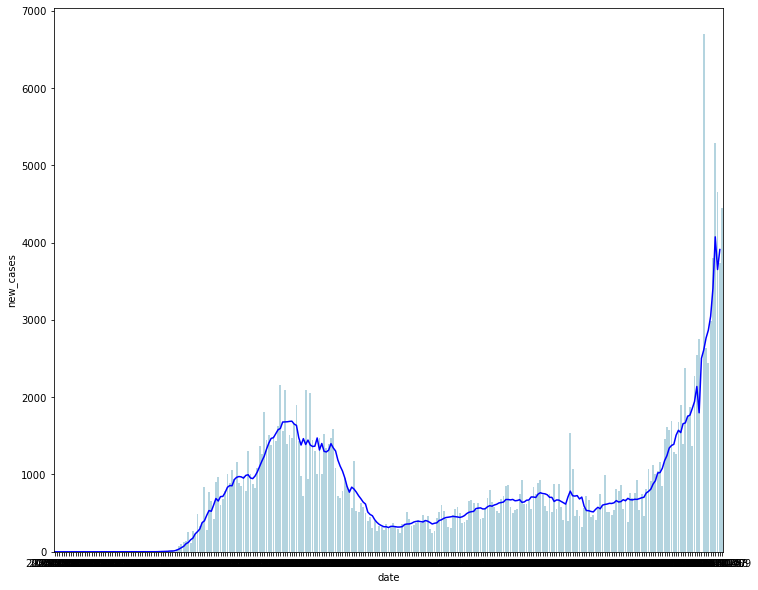

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
x = cook['date']
y = cook['7-day_avg_new']
y2 = cook['new_cases']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.barplot(x,y2, color = 'lightblue');


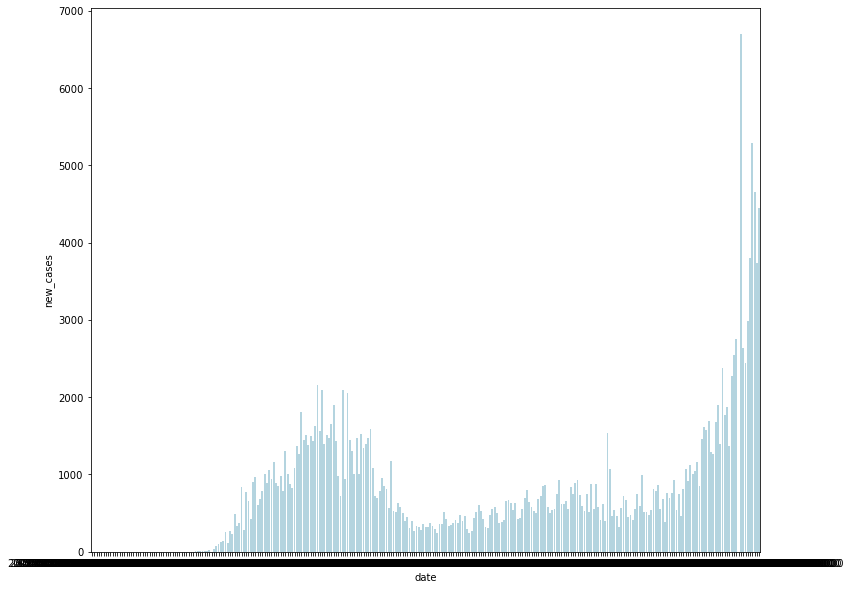

In [14]:
import datetime as dt
import matplotlib.dates as mdates

left = dt.date(2020,1,24)
right = dt.date(2020,10,31)
x = pd.to_datetime(cook['date'])
y = cook['7-day_avg_new']
y2 = cook['new_cases']

fig, ax = plt.subplots(figsize=(12,10))
ax1=sns.lineplot(x,y, color = 'blue')
ax2=sns.barplot(x,y2, color = 'lightblue');

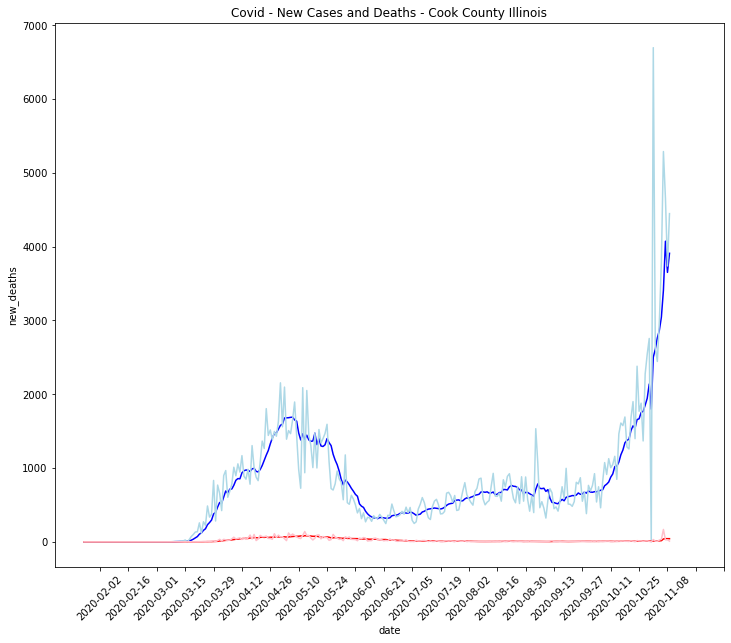

In [15]:
import numpy as np

x = cook['date']
y = cook['7-day_avg_new']
y2 = cook['new_cases']
y3 = cook['7-day_avg_death']
y4 = cook['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.lineplot(x,y2, color = 'lightblue')
sns.lineplot(x,y3, color = 'red')
sns.lineplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - New Cases and Deaths - Cook County Illinois');



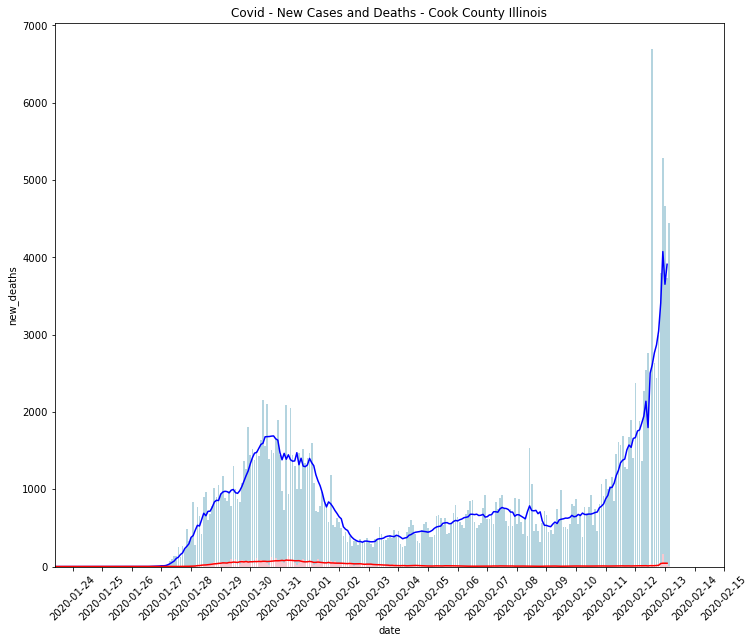

In [16]:
x = cook['date']
y = cook['7-day_avg_new']
y2 = cook['new_cases']
y3 = cook['7-day_avg_death']
y4 = cook['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.barplot(x,y2, color = 'lightblue')
sns.lineplot(x,y3, color = 'red')
sns.barplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - New Cases and Deaths - Cook County Illinois');